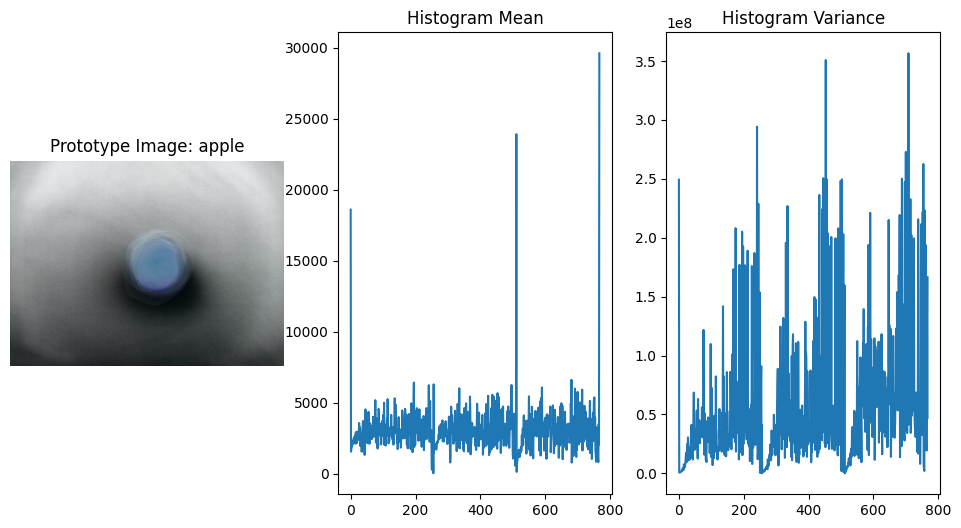

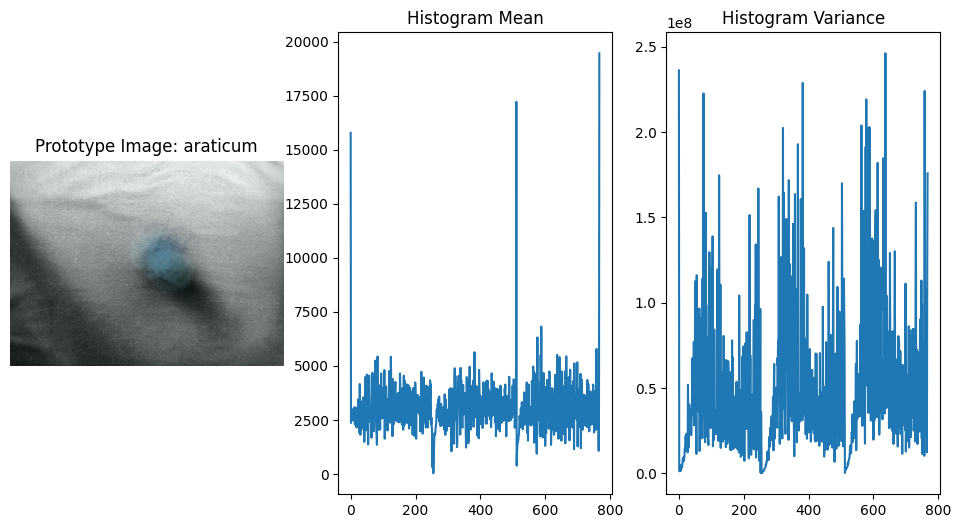

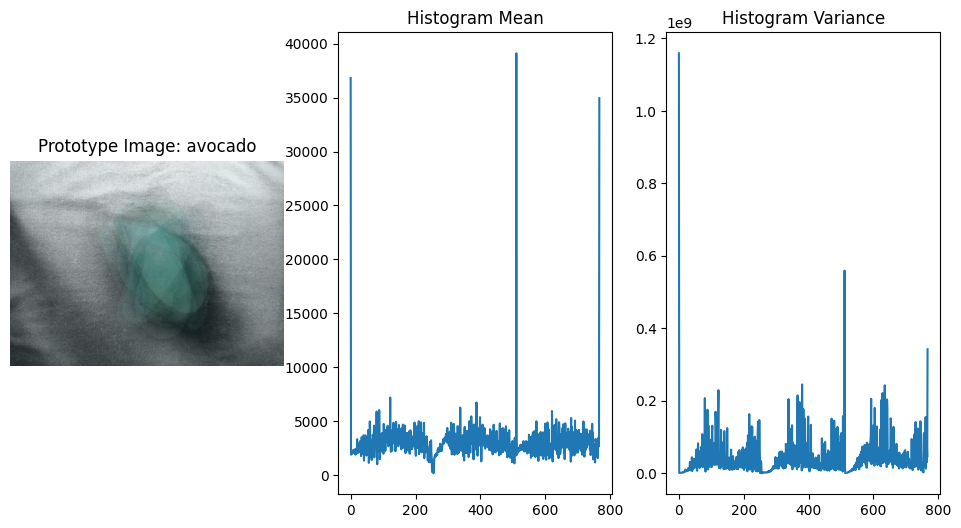

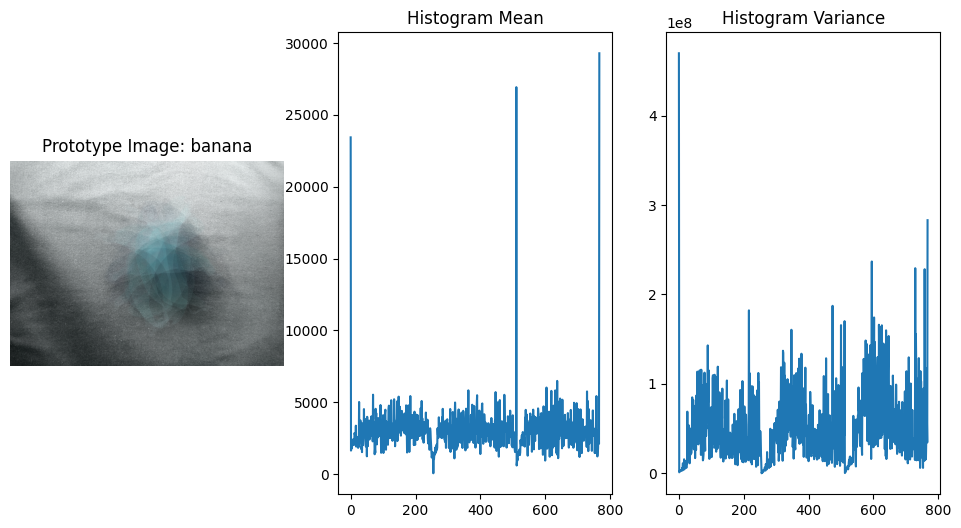

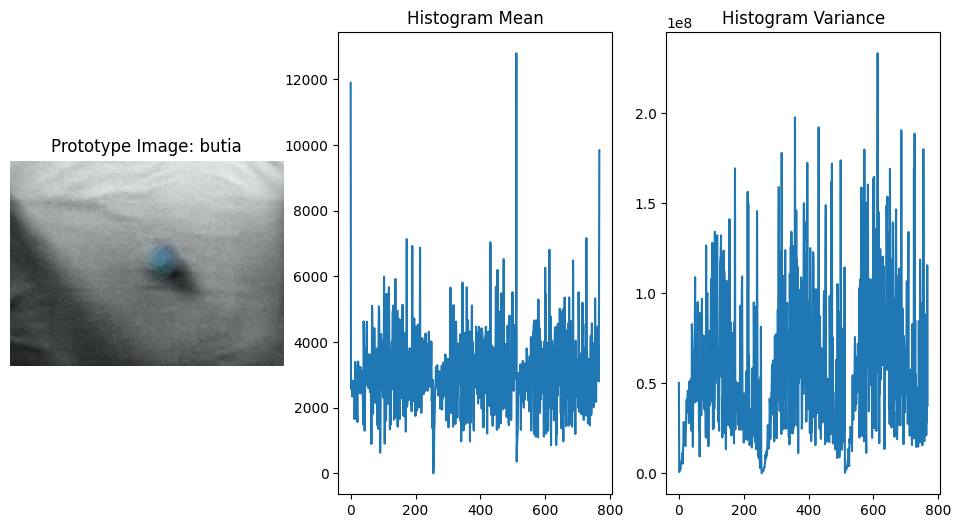

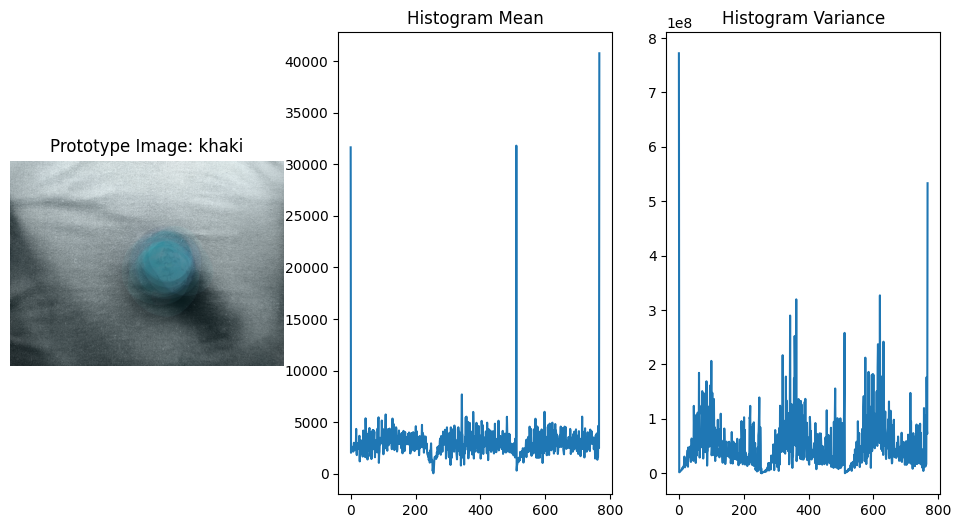

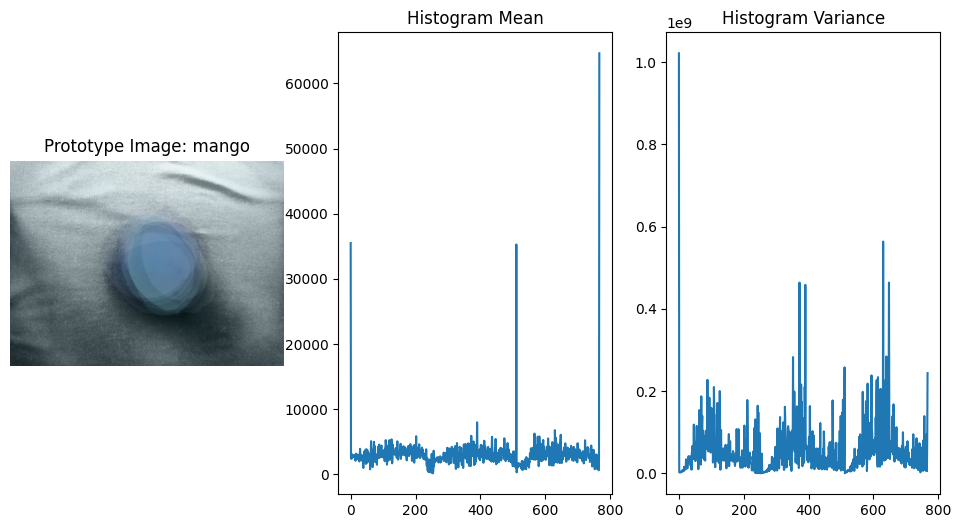

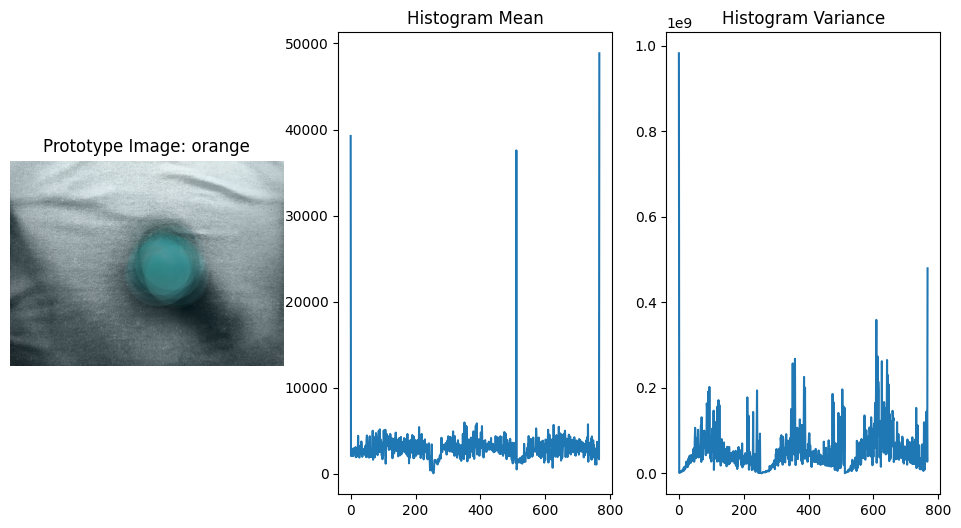

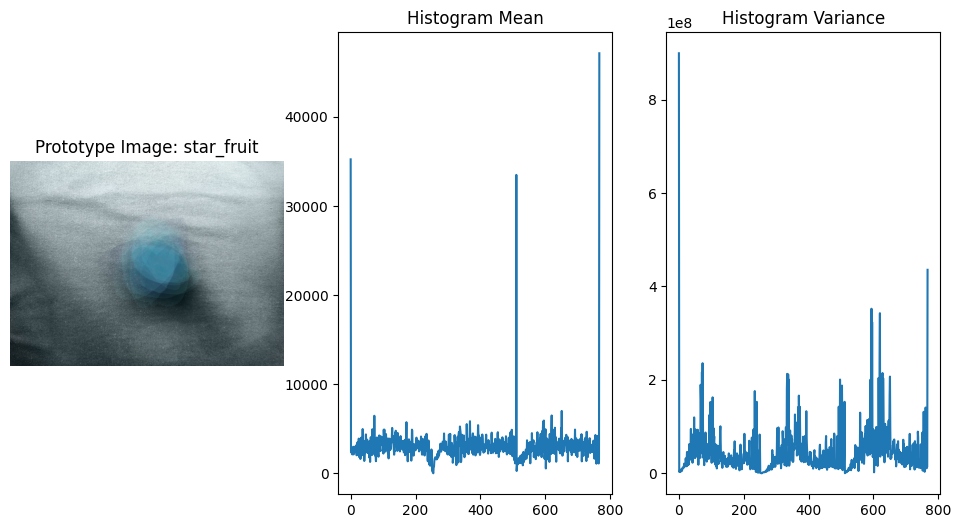

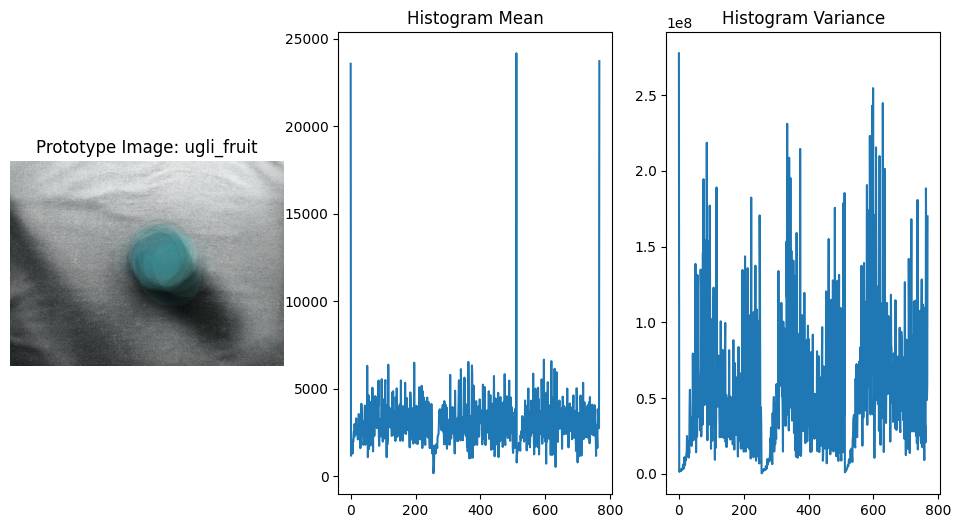

In [6]:
import gdown
import tarfile
import numpy as np
import cv2
from io import BytesIO
from skimage import io, exposure
from skimage.util import montage
import matplotlib.pyplot as plt
import os
import sys

def equalize_histogram(image):
    # Converte para YUV, equaliza o canal Y e converte de volta para RGB
    yuv = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
    yuv[:,:,0] = cv2.equalizeHist(yuv[:,:,0])
    equalized_image = cv2.cvtColor(yuv, cv2.COLOR_YUV2RGB)
    return equalized_image

def calculate_prototype(images):
    return np.mean(images, axis=0).astype(np.uint8)

def calculate_histogram(image):
    # Calcula histogramas para cada canal (RGB)
    histograms = [cv2.calcHist([image[:,:,i]], [0], None, [256], [0, 256]) for i in range(3)]
    return np.concatenate(histograms, axis=0)

def download_from_google_drive(file_id, output):
    url = f'https://drive.google.com/uc?id={file_id}'
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        try:
            sys.stdout = devnull
            sys.stderr = devnull
            gdown.download(url, output, quiet=True)
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

def process_images_from_tar_gz(file_id, fruitFolders):
    output = 'file.tar.gz'
    download_from_google_drive(file_id, output)

    # Usa BytesIO para tratar o conteúdo como um arquivo
    with open(output, 'rb') as f:
        file_like_object = BytesIO(f.read())

    # Abre o arquivo tar.gz diretamente do stream de bytes
    with tarfile.open(fileobj=file_like_object, mode='r:gz') as tar:
        # Obter todos os membros (arquivos) do .tar.gz
        members = tar.getmembers()

        # Filtrar e classificar os diretórios em ordem alfabética
        directories = sorted([m for m in members if m.isdir()], key=lambda x: x.name)

        # Assumindo que o primeiro diretório é o raiz que contém os subdiretórios
        root_directory = directories[0]

        # Filtrar os subdiretórios dentro do diretório raiz
        subdirectories = sorted([m for m in directories if m.name.startswith(root_directory.name) and m != root_directory], key=lambda x: x.name)

        for subdirectory in subdirectories:
            fruit = subdirectory.name.split('/')[-1]  # Obter o nome da fruta a partir do caminho do subdiretório
            if fruit not in fruitFolders:
                continue  # Pula se a fruta não está na lista

            # Obter arquivos de imagem no subdiretório
            images = sorted([m for m in members if m.name.startswith(subdirectory.name) and m.isfile()], key=lambda x: x.name)

            # Ler e processar as imagens
            equalized_images = []
            for img_member in images:
                file = tar.extractfile(img_member)
                if file:
                    # Ler a imagem
                    image = io.imread(file)
                    if image is None:
                        continue  # Ignora se não for uma imagem

                    # Equalizar o histograma
                    equalized_image = equalize_histogram(image)
                    equalized_images.append(equalized_image)

            # Converter para array numpy
            equalized_images_np = np.array(equalized_images)

            # Calcular a imagem protótipo (média)
            prototype = calculate_prototype(equalized_images_np)

            # Calcular histogramas
            histograms = np.array([calculate_histogram(img) for img in equalized_images])
            hist_mean = np.mean(histograms, axis=0)
            hist_variance = np.var(histograms, axis=0)

            # Exibir resultados
            plt.figure(figsize=(12, 6))

            # Exibir imagem protótipo
            plt.subplot(1, 3, 1)
            plt.title(f'Prototype Image: {fruit}')
            plt.imshow(prototype)
            plt.axis('off')

            # Exibir média do histograma
            plt.subplot(1, 3, 2)
            plt.title('Histogram Mean')
            plt.plot(hist_mean)

            # Exibir variância do histograma
            plt.subplot(1, 3, 3)
            plt.title('Histogram Variance')
            plt.plot(hist_variance)

            plt.show()

# ID do arquivo no Google Drive
file_id = '1jhzBtk4bz6ojAfhoQAVChErwl6PN8Ld1'
fruitFolders = ['apple', 'araticum', 'avocado', 'banana', 'butia', 'khaki', 'mango', 'orange', 'star_fruit', 'ugli_fruit']
process_images_from_tar_gz(file_id, fruitFolders)
